# 深層学習スクラッチ　畳み込みニューラルネットワーク2  

＜目的＞  
- スクラッチを通してCNNの基礎を理解する

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


＜データセットの用意＞  
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。   
今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。  
``(n_samples, n_channels, height, width)``の``NCHW``または``(n_samples, height, width, n_channels)``の``NHWC``どちらかの形にしてください。

In [32]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import copy
from sklearn import metrics 
from scipy.special import expit
from IPython.display import Image

In [2]:
# データセットのロード、確認
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# チャネルの軸を追加（NHCV形式）
X_train = X_train[:,None]
X_val = X_val[:,None]

print(X_train.shape) 
print(X_val.shape) 

(48000, 1, 28, 28)
(12000, 1, 28, 28)


### 【問題1】2次元畳み込み層の作成  
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。  
フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列の$i$行$j$列、$m$チャンネルの値  
$i$ : 配列の行方向のインデックス  
$j$ : 配列の列方向のインデックス  
$m$ : 出力チャンネルのインデックス  
$K$ : 入力チャンネル数  
$F_{h}, F_{w}$ : 高さ方向$（h）$と幅方向$（w）$のフィルタのサイズ  
$x_{(i+s),(j+t),k}$ : 入力の配列の$(i+s)$行$(j+t)$列、$k$チャンネルの値  
$w_{s,t,k,m}$ : 重みの配列の$s$行$t$列目。$k$チャンネルの入力に対して、$m$チャンネルへ出力する重み  
$b_m$ : $m$チャンネルへの出力のバイアス項  

全てスカラーです。  
次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配  

勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。  

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列の$i$行$j$列、$m$チャンネルの値  
$N_{out,h},N_{out,w}$ : 高さ方向$（h）$と幅方向$（w）$の出力のサイズ  

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列の$i$列$j$行、$k$チャンネルの値  
$M$ : 出力チャンネル数  

ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

### 【問題2】2次元畳み込み後の出力サイズ  
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ  

$h$ が高さ方向、 $w$ が幅方向である

In [77]:
class Conv2D:
    """
    2次元の畳み込み層

    Parameters
    ----------
    filter_size : tuple
      フィルターの形状
    n_padding : tuple
      パディングの高さ、幅
    n_stride : tuple
      ストライドの高さ、幅
    initializer : str
      初期化手法を指定するストリングス    
    activator : str
      活性化関数を指定するストリングス    
    optimizer : str
    　最適化手法を指定するストリングス

    """
    def __init__(self, filter_size, n_padding, n_stride, initializer, activator, optimizer):
        self.F = filter_size
        self.P = n_padding
        self.S = n_stride
        self.initializer = initializer 
        self.activator = activator 
        self.optimizer =  optimizer
    
    # 問題2　出力サイズの計算
    def _output_size(self, I, P, S, F):
        # 入出力はnp.array
        O = (I + P*2 - F)/S + 1
        return O.astype(int)
    
    # im2col スクラッチ
    def _im2col(self, X, P, S, F, O):
        # 変数初期化
        N, C, H, W = X.shape
        PH, PW = P
        SH, SW = S
        FH, FW = F
        OH, OW = O
        
        # マップ初期化
        X_map = np.zeros([N, C, FH*FW, OH*OW])
        
        # colの個数分ループ
        for h in range(OH):
            for w in range(OW):
                # 該当する入力にPadding
                x = np.pad(X, [(0,0),(0,0),(PH,PH),(PW,PW)], 'constant')
                # Patchを取り出してベクトル化
                col = x[:,:,h*SH:h*SH+FH, w*SW:w*SW+FW].reshape(N, C, FH*FW)
                # マップの該当列を更新
                X_map[:,:,:,h*OH+w] = col
        
        # N,C,FH×FW,OH×OW → C,FH×FW,N,OH×OWへ移動後に変形
        X_map = X_map.transpose(1,2,0,3)
        X_map = X_map.reshape(C*FH*FW, N*OH*OW)
        return X_map 
    
    # 順伝播
    def forward(self, X, y):
        # 変数初期化
        N, C, H, W = X.shape
        I = np.array([H, W])
        FN, C, FH, FW = self.F
        F = np.array([FH, FW])
        SH, SW = self.S
        S = np.array([SH, SW])
        
        # W,B初期化
        self.W = self.initializer.param(FN, C, FH, FW)
        self.B = self.initializer.param(FN, 1, 1, 1)
        self.B = self.B.reshape(FN, 1)
        
        # Paddingの入出力不変設定
        if self.P == 'keep':
            PH, PW = ((np.array(I)-1)*(np.array(S)-1)-1+np.array(F))/2
            P = np.array([PH, PW]).astype(int)
        else:
            P = np.array(self.P)
        
        # 出力サイズ計算
        O = self._output_size(I, P, S, F)
        OH, OW = O
        
        # im2colでマップを取得
        self.X_map = self._im2col(X, P, S, F, O)
        
        # W（FN,C,FH,FW）も行列へ変形
        W_map = self.W.reshape(FN, -1)
        
        # (FN,C×FH×FW) @ (C×FH×FW, N×OH×OW) →(FN, N×OH×OW)　
        A_map = W_map @ self.X_map + self.B
        
        # (FN, N×OH×OW) → (N,FN,OH,OW)
        A = A_map.reshape(FN, N, OH, OW)
        A = A.transpose(1,0,2,3)
        
        # 活性化関数を通し、Zを得る
        Z = self.activator.activate(A, y)
        
        # Backward用の変数保持
        I = (N, C, H, W)
        F = (FN, C, FH, FW)
        self.variables = (I, P, S, F, O)
        
        return Z
    
    # 逆伝播
    def backward(self, dZ):
        # 変数初期化
        I, P, S, F, O = self.variables
        N, C, H, W = I
        PH, PW = P
        SH, SW = S
        FN, C, FH, FW = F
        OH, OW = O
        
        # 活性化関数を通し、dAを得る
        dA = self.activator.jacobian(dZ)
        
        # (N,FN,OH,OW) → (1,FN,1,1)
        dB = np.sum(dA, axis=(0,2,3))
        self.dB = dB.reshape(FN, 1)
        
        # (N,FN,OH,OW) → (FN,N×OH×OW)
        dA = dA.transpose(1,0,2,3)
        dA_map = dA.reshape(FN, -1)
        
        # (FN,N×OH×OW) @ (N×OH×OW, C×FH×FW) →(FN, C×FH×FW)
        # 平均ならNで除算だが、今回はしない
        dW_map = (dA_map @ self.X_map.T)
        
        # (FN,C×FH×FW) →(FN,C,FH,FW)
        self.dW = dW_map.reshape(FN, C, FH, FW)
        
        # dXを求めるためのマップ初期化
        dF = np.zeros([FN, C, H+2*PH, W+2*PW, OH, OW])
        
        # Patchの個数ループ
        for h in range(OH):
            for w in range(OW):
                # Wを3次元の階段状に配置
                dF[:,:,h*SH:h*SH+FH, w*SW:w*SW+FW, h, w] = self.W
        # (FN,C,H+2PH,W+2PW,OH,OW) → (FN×OH×OW, C×(H+2PH)×(W+2PW))
        dF = dF.transpose(0,4,5,1,2,3)
        dF_map = dF.reshape(FN*OH*OW, -1)
        
        # (FN,N,OH,OW) → (N,FN×OH×OW)
        dA = dA.transpose(1,0,2,3)
        dA_map = dA.reshape(N, -1)
        
        # (N,FN×OH×OW) @ (FN×OH×OW, C×(H+2PH)×(W+2PW)) → (N, C×(H+2PH)×(W+2PW))
        # 平均ならFNで除算だが、今回はしない
        dX_map = (dA_map @ dF_map)
        
        # (N, C×(H+2PH)×(W+2PW)) → (N,C,H,W)
        dX = dX_map.reshape(N, C, H+2*PH, W+2*PW)
        if PH != 0:
            dX = dX[:, :, PH:-PH, :]
        if PW != 0:
            dX = dX[:, :, :, PW:-PW]
        
        # dXを計算後、W,Bを更新
        self.optimizer.update(self)

        return dX

In [149]:
# 小さな配列で確認
conv = Conv2D(filter_size=(2,1,3,3), 
              n_padding=(1,1), 
              n_stride=(2,2), 
              initializer=HeInitializer(1), 
              activator=ReLU(), 
              optimizer=SGD(0.1))

X_1 = np.arange(1,10).reshape(3,3)
X_2 = np.arange(1,10).reshape(3,3)*2
X = np.array([[X_1],[X_2]])
y = None
print('X', X)
print('X.shape', X.shape)

Z = conv.forward(X, y)
print('\nZ', Z)
print('Z.shape', Z.shape)

dZ = conv.backward(Z/100)
print('\ndZ', dZ)
print('dZ.shape', dZ.shape)

X [[[[ 1  2  3]
   [ 4  5  6]
   [ 7  8  9]]]


 [[[ 2  4  6]
   [ 8 10 12]
   [14 16 18]]]]
X.shape (2, 1, 3, 3)
W [[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]
W.shape (2, 1, 3, 3)
B [[0.1]
 [0.2]]
(2, 1)
X_map [[ 0.  0.  0.  5.  0.  0.  0. 10.]
 [ 0.  0.  4.  6.  0.  0.  8. 12.]
 [ 0.  0.  5.  0.  0.  0. 10.  0.]
 [ 0.  2.  0.  8.  0.  4.  0. 16.]
 [ 1.  3.  7.  9.  2.  6. 14. 18.]
 [ 2.  0.  8.  0.  4.  0. 16.  0.]
 [ 0.  5.  0.  0.  0. 10.  0.  0.]
 [ 4.  6.  0.  0.  8. 12.  0.  0.]
 [ 5.  0.  0.  0. 10.  0.  0.  0.]]
A_map (2, 8)

Z [[[[12.1 16.1]
   [24.1 28.1]]

  [[12.2 16.2]
   [24.2 28.2]]]


 [[[24.1 32.1]
   [48.1 56.1]]

  [[24.2 32.2]
   [48.2 56.2]]]]
Z.shape (2, 2, 2, 2)
dB [[2.408]
 [2.416]]
(2, 1)
dW [[[[ 7.015 13.23   6.015]
   [12.83  24.06  10.83 ]
   [ 4.015  7.23   3.015]]]


 [[[ 7.03  13.26   6.03 ]
   [12.86  24.12  10.86 ]
   [ 4.03   7.26   3.03 ]]]]
(2, 1, 3, 3)

dZ [[[[0.243 0.566 0.323]
   [0.726 1.612 0.886]


### 【問題3】最大プーリング層の作成  
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : $i$行$j$列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行$（p）$と列$（q）$  
$S_{h}, S_{w}$ : 高さ方向$（h）$と幅方向$（w）$のストライドのサイズ  
$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行$（p）$と列$（q）$のインデックス  
$a_{i,j,m}$ : 出力される配列の$i$行$j$列、$k$チャンネルの値  
$x_{p,q,k}$ : 入力の配列の$p$行$q$列、$k$チャンネルの値  

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。  
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [4]:
class MaxPool2D:
    """
    最大プーリング層

    Parameters
    ----------
    filter_size : tuple
      フィルターの形状
    """
    
    def __init__(self, filter_size):
        self.F = filter_size

    def _im2col(self, X, F, O):
        # 変数初期化
        N, C = X.shape[0], X.shape[1]
        FH, FW = F
        OH, OW = O
        
        # マップ初期化
        X_map = np.zeros([N, C, FH*FW, OH*OW])
        
        # colの個数分ループ
        for h in range(OH):
            for w in range(OW):
                # Patchを取り出してベクトル化
                col = X[:,:,h*FH:(h+1)*FH, w*FW:(w+1)*FW].reshape(N, C, FH*FW)
                # マップの該当列を更新
                X_map[:,:,:,h*OH+w] = col
        # (N,C,FH*FW,OH*OW )→ (FH*FW,N,C,OH*OW)へ移動後に変形
        X_map = X_map.transpose(2,0,1,3)
        X_map = X_map.reshape(FH*FW, N*C*OH*OW)
        
        return X_map 
    
    # 順伝播
    def forward(self, X, y):
        # 変数初期化
        N, C, H, W = X.shape
        I = np.array([H, W])
        FH, FW = self.F
        F = np.array(self.F)
        O = I // F
        OH, OW = O
        
        # im2colでマップ取得
        X_map = self._im2col(X, F, O)
        
        # FH*FW軸方向で最大値とインデックス取得
        X_max = np.amax(X_map, axis=0)
        self.indices = np.argmax(X_map, axis=0)
        
        # (1,N*C*OH*OW) → (N,C,OH,OW)
        X_max = X_max.reshape(N, C, OH, OW)  
        
        # Backward用の変数保持
        I = (N, C, H, W)
        F = (FH, FW)
        self.variables = (I, F, O)
        
        return X_max
    
    def _col2im(self, X_map, I, F, O):
        # 変数初期化
        N, C, H, W = I
        FH, FW = F
        OH, OW = O
        
        # (FH*FW,N*C*OH*OW) → (N,C,FH*FW,OH*OW)
        X_map = X_map.reshape(FH*FW, N, C, OH*OW)
        X_map = X_map.transpose(1,2,0,3)
        # 画像初期化
        X = np.zeros(I)
        
        # パッチの個数ループ
        for h in range(OH):
            for w in range(OW):
                # マップの該当列をパッチへ変換
                im = X_map[:,:,:,h*OH+w].reshape(N, C, FH, FW)
                # 画像の該当パッチを更新
                X[:,:,h*FH:(h+1)*FH, w*FW:(w+1)*FW] = im
        
        return X
    
    # 逆伝播
    def backward(self, dX):
        # 変数初期化
        I, F, O = self.variables
        N, C, H, W = I
        FH, FW = F
        OH, OW = O
        
        # (N,C,OH,OW) → (FH*FW,N*C*OH*OW) 
        dX_max = dX.reshape(1, -1)
        dX_max = np.tile(dX_max, (FH*FW, 1))
        
        # 最大値のインデックスをone hot形へ変換
        R = np.eye(FH*FW)[self.indices].T
        
        # マップとアダマール積し、該当部以外を0にする
        dX_map = dX_max*R
        
        # col2imで画像へ戻す
        dX = self._col2im(dX_map, I, F, O)
        
        return dX

In [5]:
# 小さな配列で確認
pool = MaxPool2D(filter_size=(2,2))

X = np.zeros([2,1,4,4])
for i in range(2):
    for j in range(4):
        for k in range(4):
            X[i,:,j,k] = np.random.randint(1,16)

print('X',X)
y = None
Z = pool.forward(X, y)
print('\nZ', Z)
dZ = pool.backward(Z/10)
print('\ndZ', dZ)

X [[[[ 7. 10. 10.  9.]
   [ 2. 11. 15.  8.]
   [ 2. 14.  7. 15.]
   [ 3.  2.  3.  8.]]]


 [[[ 2.  2. 13.  2.]
   [ 4.  9.  3.  6.]
   [ 2. 13.  2.  2.]
   [ 9.  9.  2.  6.]]]]

Z [[[[11. 15.]
   [14. 15.]]]


 [[[ 9. 13.]
   [13.  6.]]]]

dZ [[[[0.  0.  0.  0. ]
   [0.  1.1 1.5 0. ]
   [0.  1.4 0.  1.5]
   [0.  0.  0.  0. ]]]


 [[[0.  0.  1.3 0. ]
   [0.  0.9 0.  0. ]
   [0.  1.3 0.  0. ]
   [0.  0.  0.  0.6]]]]


### 【問題4】平均プーリングの作成  
平均プーリング層のクラスAveragePool2Dを作成してください。  
範囲内の最大値ではなく、平均値を出力とするプーリング層です。  
画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [6]:
class AveragePool2D:
    """
    平均プーリング層

    Parameters
    ----------
    filter_size : tuple
      フィルターの形状
    """
    def __init__(self, filter_size):
        self.F = filter_size

    def _im2col(self, X, F, O):
        
        N, C = X.shape[0], X.shape[1]
        FH, FW = F
        OH, OW = O
        
        X_map = np.zeros([N, C, FH*FW, OH*OW])
        
        for h in range(OH):
            for w in range(OW):
                col = X[:,:,h*FH:(h+1)*FH, w*FW:(w+1)*FW].reshape(N, C, FH*FW)
                X_map[:,:,:,h*OH+w] = col
        
        X_map = X_map.traspose(2,0,1,3)
        X_map = X_map.reshape(FH*FW, N*C*OH*OW)
        
        return X_map 
    
    # 順伝播
    def forward(self, X, y):
        N, C, H, W = X.shape
        I = np.array([H, W])
        FH, FW = self.F
        F = np.array(self.F)
        O = I // F
        OH, OW = O
        
        X_map = self._im2col(X, F, O)
        
        X_mean = np.mean(X_map, axis=0)
        
        X_mean = X_mean.reshape(N, C, OH, OW)
        
        I = (N, C, H, W)
        F = (FH, FW)
        
        self.variables = (I, F, O)
        
        return X_max
    
    def _col2im(self, X_map, I, F, O):
        
        N, C, H, W = I
        FH, FW = F
        OH, OW = O
        
        X_map = X_map.transpose(1,2,0,3)
        X = np.zeros(I)
        
        for h in range(OH):
            for w in range(OW):
                im = X_map[:,:,:,h*OH+w].reshape(N, C, FH, FW)
                X[:,:,h*FH:(h+1)*FH, w*FW:(w+1)*FW] = im
        
        return X
    
    # 逆伝播
    def backward(self, dX):
        
        I, F, O = self.variables
        N, C, H, W = I
        FH, FW = F
        OH, OW = O
        
        dX_mean = dX.reshape(1, -1)
        dX_map = np.tile(dX_mean, (FH*FW, 1))
        
        dX = self._col2im(dX_map, I, F, O)
        
        return dX

### 【問題5】平滑化  
平滑化するためのFlattenクラスを作成してください。  
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。  
この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [5]:
class Flatten:
    """
    平滑化層
　　"""
    # 順伝播
    def forward(self, X, y):
        # 変数初期化
        N, C, H, W = X.shape
        # 平滑化
        X_flat = X.reshape(N, -1)
        # Backward時の変数保持
        self.I = (N, C, H, W)
        
        return X_flat
    
    # 逆伝播
    def backward(self, dX_flat):
        # 入力と同じ形状へ変形
        dX = dX_flat.reshape(self.I)
        
        return dX

### 【問題6】学習と推定  
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。  
精度は低くともまずは動くことを目指してください。

In [6]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : object
    　初期化方法のインスタンス
    activator : object
    　活性化関数のインスタンス
    optimizer : object
    　最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, activator, optimizer):
        # initializerでBias成分を付け加えself.Wを初期化
        # 4次元で作成し次元削除
        self.W = initializer.param(n_nodes1 + 1, n_nodes2, 1, 1)
        self.W = self.W.reshape(n_nodes1 + 1, n_nodes2)
        self.B = None 
        # 活性化関数、最適化手法も受け取る
        self.activator = activator
        self.optimizer = optimizer
    
    # 順伝播
    def forward(self, X, y):
        self.X = np.insert(X, 0, 1, axis=1)
        # バッチサイズ保持
        self.N = X.shape[0]
        self.A = self.X @ self.W
        # 活性化関数を通し、Zを出力する形にする
        return self.activator.activate(self.A, y)
    
    # 逆伝播
    def backward(self, y):
        # 活性化関数のヤコビアンを通し、dAを得る
        dA = self.activator.jacobian(y)
        # 層の入力とバッチサイズから、E(dW)を得る
        self.dW = ((self.X).T @ dA) / self.N
        # WのBias成分である1行目を落とし、次に渡すdZを得る
        W = np.delete(self.W, 0, 0)
        dZ = dA @ W.T
        # 上記を作成後、受け取った最適化手法でWを更新
        self.optimizer.update(self)
        return dZ

In [7]:
# Heの初期値
class HeInitializer:
    """
    He法による初期化
    Parameters
    ----------
    n_nodes1 : float
      前の層のノード数
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2 / n_nodes1)
        
    """
        重みの初期化
        Parameters
        ----------
        A,B,C,D : int
          4次元までの重みの形状
        
        Returns
        ----------
        W :次の形のndarray, shape (A, B, C, D)
          初期化された重み
        """
        
    def param(self, A, B, C, D):
        # 畳み込み層に合わせ、4次元までの形状に対応
        param = self.sigma * np.random.randn(A, B, C, D)
        return param

In [8]:
# Relu関数
class ReLU:
    # 順伝播時の関数メソッド（softmaxに合わせ、yも引数にとるが使用しない）
    def activate(self, A, y):
        # 逆伝播時に使用する変数を保持
        self.Z = np.maximum(A, 0)
        return self.Z
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, dZ):
        dA = dZ*(np.where(self.Z==0, 0, 1))
        return dA

In [9]:
# ソフトマックス関数
class Softmax:
    # 順伝播時の関数メソッド
    def activate(self, A, y):
        exp_sigma = np.sum(np.exp(A), axis=1)[:, np.newaxis]
        sigma_matrix = np.tile(exp_sigma, (1, A.shape[1]))
        # 逆伝播時に使用する変数を保持
        self.Z = np.exp(A)/sigma_matrix
        # 学習時はエントロピーを返す
        if y is not None:
            entropy = np.sum(np.log(self.Z)*y)/A.shape[0]*(-1)
            output = entropy
        # 推定時は予測行列を返す
        else:
            output = self.Z
        return output
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, y):
        dA = self.Z - y
        return dA

In [10]:
class AdaGrad:
    """
    学習係数減衰勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.Hw = None
        self.Hb = None
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
    　　layer : object
          更新前の層のインスタンス
        """
        if self.Hw is None:
            self.Hw = np.zeros_like(layer.dW)
        self.Hw += layer.dW**2
        # zero division回避のため小さな値を加える
        layer.W -= self.lr/(np.sqrt(self.Hw) + 1e-7)*layer.dW
        
        if layer.B is not None:
            if self.Hb is None:
                self.Hb = np.zeros_like(layer.dB)
            self.Hb += layer.dB**2
            layer.B -= self.lr/(np.sqrt(self.Hb) + 1e-7)*layer.dB
            
        
        return self

In [29]:
class Momentum:
    """
    学習係数減衰勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.Vw = None
        self.Vb = None
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : object
          更新前の層のインスタンス
        """
        if self.Vw is None:
            self.Vw = np.zeros_like(layer.dW)
        self.Vw = 0.8*self.Vw - self.lr*layer.dW
        layer.W += self.Vw
        
        if layer.B is not None:
            if self.Vb is None:
                self.Vb = np.zeros_like(layer.dB)
            self.Vb = 0.8*self.Vb - self.lr*layer.dB
            layer.B += self.Vb
        
        return self

In [11]:
# mini Batch取得クラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [25]:
# CNNクラス
class ScratchConvolutionalNeuralNetrowkClassifier():
    """
    CNN分類器

    Parameters
    ----------
    layers : list
      学習層
    batch_size : int
    　学習時のミニバッチサイズ
    epoch : int
    　学習のエポック数
    interval : int
    　クロスエントロピー記録のiterationに対する間隔
    verbose : bool
    　クロスエントロピー出力の有無

    Attributes
    ----------
    self.cross_entropys : list
      訓練データ学習時のクロスエントロピー格納リスト
    self.cross_entropys_val : list
    　検証データのクロスエントロピー格納リスト
    """
    def __init__(self, layers, batch_size, epoch, interval, verbose):
        self.layers = layers
        self.batch_size = batch_size
        self.epoch = epoch
        self.interval = interval
        self.verbose = verbose
        # 以下はAttributes
        self.cross_entropys = []
        self.cross_entropys_val = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.n_layers = len(self.layers)
        
        # 訓練/検証データの正解ラベルをone-hotへ
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        if y_val is not None:
            y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
        
        # epochのループ
        for e in range(self.epoch):
            # ミニバッチのインスタンス生成
            mini_batch_train = GetMiniBatch(X, y_one_hot, self.batch_size)
            # エントロピー記録時に使うループ数を初期化
            n_iter = 0
            # バッチのループ
            for mini_X_train, mini_y_train in mini_batch_train:
                
                # 検証データサイズが大きいため、指定したインターバル時のみforward
                if X_val is not None and n_iter % self.interval == 0:
                    # forward用の変数作成
                    Z_val = copy.deepcopy(X_val)
                    # 層のループ
                    for c in range(self.n_layers):
                        # 指定した結合層で、変数を更新していく
                        layer = self.layers[c]
                        Z_val = layer.forward(Z_val, y_val_one_hot)
                        #print(c, Z_val.shape)
                    # エントロピー格納
                    self.cross_entropys_val.append(Z_val)
                
                # 訓練データの変数作成
                y = mini_y_train
                Z = copy.deepcopy(mini_X_train)
                
                # 検証データと同様のforward
                for c in range(self.n_layers):
                    layer = self.layers[c]
                    Z = layer.forward(Z, y)
                    #print(c+1, Z.shape)
                # 指定したインターバル時にエントロピー格納
                if n_iter % self.interval == 0:
                    self.cross_entropys.append(Z)
                
                # 訓練データのforward直後に、変数を作成しbackwardを行う
                dZ = copy.deepcopy(y)
                for c in range(self.n_layers):
                    # 指定した結合層で、変数を更新していく
                    layer = self.layers[self.n_layers-1-c]
                    dZ = layer.backward(dZ)
                    
                # インターバル用のループ数を1増やす
                n_iter += 1

        # verboseの場合、Cross Etropyのリストを出力する
        if self.verbose:
            print('Cross Entropy (train) :\n', self.cross_entropys)
            if X_val is not None and y_val is not None:
                print('Cross Entropy (Validation) :\n', self.cross_entropys_val)
        
        return self

    
    def predict(self, X):
        
        # y=Noneとしてforward
        for c in range(self.n_layers):
            layer = self.layers[c]
            X = layer.forward(X, y=None)
        # 予測行列が帰るので、ラベルへ変換し出力
        pred_matrix = X
        return np.argmax(pred_matrix, axis=1)

In [14]:
conv = Conv2D(filter_size=(5,1,7,7), 
              n_padding=(2,2), 
              n_stride=(1,1),
              initializer=HeInitializer(784), 
              activator=ReLU(), 
              optimizer=AdaGrad(0.1))

pool = MaxPool2D(filter_size=(3,3))

flat = Flatten()

affine_1 = FC(320, 
              40, 
              initializer=HeInitializer(320), 
              activator=ReLU(), 
              optimizer=AdaGrad(0.1))

affine_2 = FC(40, 
              20, 
              initializer=HeInitializer(40), 
              activator=ReLU(), 
              optimizer=AdaGrad(0.1))

softmax = FC(20, 
             10, 
             initializer=HeInitializer(20), 
             activator=Softmax(), 
             optimizer=AdaGrad(0.1))

layers = [conv, pool, flat, affine_1, affine_2, softmax]

scnn = ScratchConvolutionalNeuralNetrowkClassifier(layers=layers, 
                                                   batch_size=50, 
                                                   epoch=10, 
                                                   interval=960, 
                                                   verbose=True)

scnn.fit(X_train, y_train, X_val, y_val)

0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
0 (12000, 5, 26, 26)
1 (12000, 5, 8, 8)
2 (12000, 320)
3 (12000, 40)
4 (12000, 20)
5 ()
Cross Entropy (train) :
 [2.3614669072092362, 0.7406605733962034, 0.6491094437574025, 0.6211592007042939, 0.611546524010

In [19]:
# 学習曲線描画関数
def learning_curve(n_record, loss, loss_val):
    plt.plot(np.arange(n_record), loss, label='train_loss')
    plt.plot(np.arange(n_record), loss_val, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iteration / interval')
    plt.ylabel('cross entropy')
    plt.legend()
    plt.show()

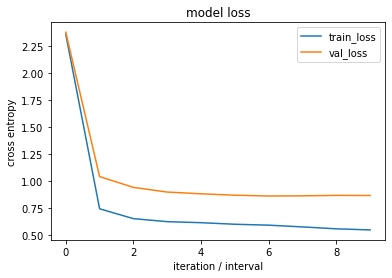

< Metrics >
Accuracy : 0.786


In [43]:
# 学習曲線
learning_curve(10, scnn.cross_entropys, scnn.cross_entropys_val)


# Accuracy算出
print('< Metrics >')
y_pred = scnn.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- 学習は頭打ちで、全結合層のみよりも成績は悪い
- Momentum最適化も試してみる

In [30]:
conv = Conv2D(filter_size=(5,1,7,7), 
              n_padding=(2,2), 
              n_stride=(1,1),
              initializer=HeInitializer(784), 
              activator=ReLU(), 
              optimizer=Momentum(0.1))

pool = MaxPool2D(filter_size=(3,3))

flat = Flatten()

affine_1 = FC(320, 
              40, 
              initializer=HeInitializer(320), 
              activator=ReLU(), 
              optimizer=Momentum(0.1))

affine_2 = FC(40, 
              20, 
              initializer=HeInitializer(40), 
              activator=ReLU(), 
              optimizer=Momentum(0.1))

softmax = FC(20, 
             10, 
             initializer=HeInitializer(20), 
             activator=Softmax(), 
             optimizer=Momentum(0.1))

layers = [conv, pool, flat, affine_1, affine_2, softmax]

scnn_m = ScratchConvolutionalNeuralNetrowkClassifier(layers=layers, 
                                                     batch_size=50, 
                                                     epoch=10, 
                                                     interval=960, 
                                                     verbose=True)

scnn_m.fit(X_train, y_train, X_val, y_val)

Cross Entropy (train) :
 [2.2791539972062362, 0.971993940124725, 0.5969941596194355, 0.5839384390047077, 0.4944679099287892, 0.5182505256211286, 0.5534593398504776, 0.5360289151121089, 0.5774726714159079, 0.6200632715779645]
Cross Entropy (Validation) :
 [2.342543560186436, 1.2052770056399604, 0.8692465693211263, 1.0048697019099833, 0.8440500353156073, 0.8343222666938147, 0.7916922277114584, 0.7931254521261436, 0.7893242959282788, 0.8622625852672532]


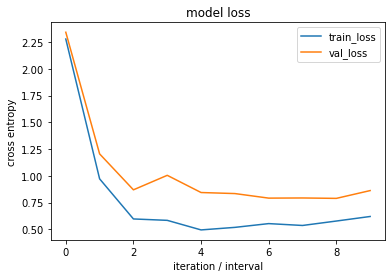

< Metrics >
Accuracy : 0.821


In [42]:
# 学習曲線
learning_curve(10, scnn_m.cross_entropys, scnn_m.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = scnn_m.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- AdaGradと著変なく、Epochを重ねても学習は進みそうにない

### 【問題7】LeNet  
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の **LeNet** です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。  

- 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数

In [44]:
# LeNet構成
conv_1 = Conv2D(filter_size=(6,1,5,5), 
                n_padding='keep', 
                n_stride=(1,1),
                initializer=HeInitializer(784), 
                activator=ReLU(), 
                optimizer=AdaGrad(0.1))

pool_1 = MaxPool2D(filter_size=(2,2))

conv_2 = Conv2D(filter_size=(16,6,5,5), 
                n_padding=(0,0), 
                n_stride=(1,1),
                initializer=HeInitializer(1176), 
                activator=ReLU(), 
                optimizer=AdaGrad(0.1))

pool_2 = MaxPool2D(filter_size=(2,2))

flat = Flatten()

affine_1 = FC(400, 
              120, 
              initializer=HeInitializer(400), 
              activator=ReLU(), 
              optimizer=AdaGrad(0.1))

affine_2 = FC(120, 
              84, 
              initializer=HeInitializer(120), 
              activator=ReLU(), 
              optimizer=AdaGrad(0.1))

softmax = FC(84, 
             10, 
             initializer=HeInitializer(84), 
             activator=Softmax(), 
             optimizer=AdaGrad(0.1))

layers = [conv_1, pool_1, conv_2, pool_2, flat, affine_1, affine_2, softmax]

LeNet = ScratchConvolutionalNeuralNetrowkClassifier(layers=layers, 
                                                    batch_size=100, 
                                                    epoch=10, 
                                                    interval=4800, 
                                                    verbose=True)

LeNet.fit(X_train, y_train, X_val, y_val)

Cross Entropy (train) :
 [2.362804892319831, 1.8883184688772412, 1.647033127427497, 1.4783468008310132, 1.412258735721627, 1.3064021557221344, 1.2219758791945825, 1.2002747409344827, 1.1789692535443792, 1.1352100987778813]
Cross Entropy (Validation) :
 [2.334027128879273, 2.176036726727532, 2.0524063364205114, 2.0175698082882723, 1.9936490988340625, 1.989241402478814, 1.9814516036289338, 1.974357978230111, 1.9708573618649365, 1.958259098140404]


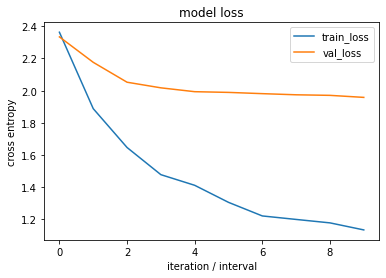

< Metrics >
Accuracy : 0.177


In [49]:
# 上記の学習で描画
learning_curve(10, LeNet.cross_entropys, LeNet.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = LeNet.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- 訓練データのlossは低下するものの、検証データのloss低下は極めて遅い
- 学習をうまく進めるには、各ハイパーパラメーターの調整が必要のようだ

### 【問題8】有名な画像認識モデルの調査  
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。  
どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

### 1. AlexNet

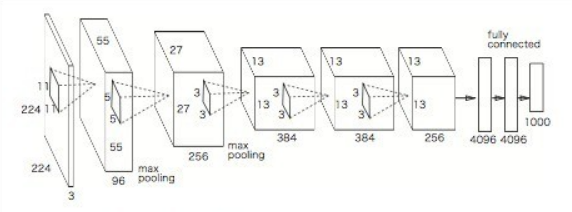

In [36]:
Image('cnn-3.png')

ネットワーク構成はLeNetと大きく変わらないが、以下の点で異なる
- 活性化関数にReLUを用いる
- LRN(Local Response Normalization)という局所的正規化を行う層を用いる
- Dropoutを使用する


### 2. VGG

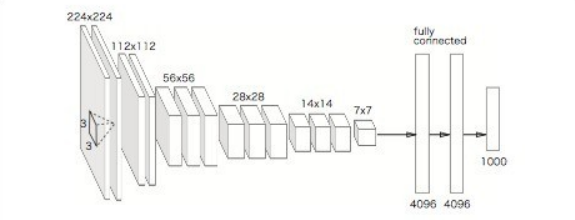

In [37]:
Image('cnn-4.png')

VGGは畳み込み層とプーリング層から構成される"基本的"なCNNであるが、層を全部で16層（もしくは19層）に重ねてディープにしている点が特徴（VGG16 / VGG19）。  
注目すべきは、3×3の小さなフィルターによる畳み込み層を連続して行っている点。図にあるように、畳み込みを2～4回連続し、プーリング層でサイズを半分にする処理を繰り返し行った後、全結合層を経由して結果を出力する。


### 3. GoogLeNet  

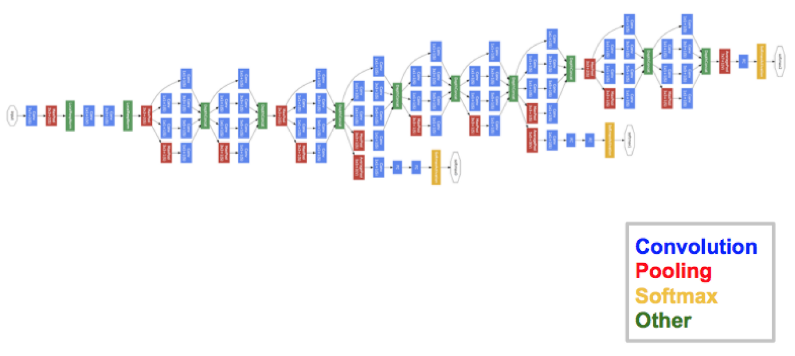

In [38]:
Image('cnn-5.png')

基本的にこれまでのCNNと同じ構成であるが、GoogLeNetはネットワークが縦方向の深さだけでなく、横方向にも深さ（広がり）を持っているという点が特徴。これは「インセプション構造」と呼ばれ、サイズの異なるフィルター（とプーリング）を複数適用し、結果を結合する。  
また、1×1フィルターの畳み込み層を多くの場所で使用し、チャンネル方向にサイズを減らすことでパラメーターの削減や処理の高速化を図っている。


### 4. ResNet  

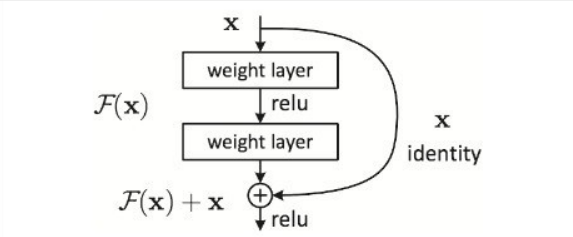

In [47]:
Image('cnn-6.png')

ResNetはMicrosoftチームによって開発され、これまで以上に層を深くできる"仕掛け"を持っている。  
性能の向上には層を深くすることが重要であることが分かっていたが、深くし過ぎると学習がうまくいかなかった。ResNetではこのような問題を解決するために「スキップ構造」を導入している。これは畳み込み層をまたいで―スキップして―出力に合算する構造であり、逆伝播の際に信号が減衰することなく伝わっていくため、効率よく学習することが可能となる。  
ResNetは先のVGGをベースに、畳み込み層を2層おきにスキップしてつなぎ、層を深くしている。なお実験により、150層以上に深くしても認識精度は向上し続けることが分かっている。

### 【問題9】出力サイズとパラメータ数の計算  
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.  
入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  

2.  
入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  

3.  
入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [51]:
# 出力サイズ計算関数
def output_size(I, P, S, F):
    C, H, W = I
    FN, FH, FW = F
    PH, PW = P
    SH, SW = S
    OH = (H + PH*2 - FH)/SH + 1
    OW = (W + PW*2 - FW)/SW + 1
    output = (FN, int(OH), int(OW))
    if OH%1 != 0 or OW%1 != 0:
        output = '({}, {}, {}) (truncated)'.format(FN, int(OH), int(OW))
    return output

# パラメーター計算関数
def calculate_param(I, F):
    C, H, W = I
    FN, FH, FW = F
    n_param = int(FH*FW*C*FN + FN)
    return n_param

In [52]:
# case 1
I = (3,144,144)
F = (6,3,3)
S = (1,1)
P = (0,0)
print('1.')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

# case 2
I = (24,60,60)
F = (48,3,3)
S = (1,1)
P = (0,0)
print('\n2.')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

# case 3
I = (10,20,20)
F = (20,3,3)
S = (2,2)
P = (0,0)
print('\n3.')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

1.
Output shape : (6, 142, 142)
Parameter size : 168

2.
Output shape : (48, 58, 58)
Parameter size : 10416

3.
Output shape : (20, 9, 9) (truncated)
Parameter size : 1820


### 【問題10】フィルタサイズに関する調査  
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。  

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

例えば、同じ28×28の領域を22×22に畳み込む場合を考える。  
フィルタサイズが 7×7 の場合と 3×3 の場合はそれぞれ以下のようになる。

In [54]:
# 7×7
I = (1,28,28)
F = (1,7,7)
S = (1,1)
P = (0,0)
print('7×7')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

7×7
Output shape : (1, 22, 22)
Parameter size : 50


In [58]:
# 3×3 (×3)
I = (1,28,28)
F = (1,3,3)
S = (1,1)
P = (0,0)
print('3×3 (×3)')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

I = (1,26,26)
F = (1,3,3)
S = (1,1)
P = (0,0)
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

I = (1,24,24)
F = (1,3,3)
S = (1,1)
P = (0,0)
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

3×3 (×3)
Output shape : (1, 26, 26)
Parameter size : 10
Output shape : (1, 24, 24)
Parameter size : 10
Output shape : (1, 22, 22)
Parameter size : 10


よってパラメーターの総数は7×7が50個に対して、3×3は30個とより少なくて済む。  
加えて、昨今の大規模画像認識コンペティションの結果が示すところでは、上位を占める手法の多くがディープラーニングによる手法である。理論的側面は現在のところ乏しいものの、認識性能を向上させるには層を深くすることが重要と考えられているため、大きなフィルターで浅く処理するよりも小さなフィルターで深く処理されることが多い。


今度はチャネル数を考慮し、3×28×28の領域に 3×3 のフィルタを適用する場合を考える。  
この時、3×3 conv の前に 1×1 conv を挟み込む手法があり、ボトルネック層と呼ばれる。チャネル数3を維持する場合、それぞれのパラメータ数は以下のように計算される。

In [67]:
# 3×3 
I = (3,28,28)
F = (3,3,3)
S = (1,1)
P = (0,0)
print('3×3')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

3×3
Output shape : (3, 26, 26)
Parameter size : 84


In [76]:
# 1×1 → 3×3 
I = (3,28,28)
F = (3,1,1)
S = (1,1)
P = (0,0)
print('1×1 → 3×3')
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

I = (1,28,28)
F = (3,3,3)
S = (1,1)
P = (0,0)
print('Output shape : {}'.format(output_size(I, P, S, F)))
print('Parameter size : {}'.format(calculate_param(I, F)))

1×1 → 3×3
Output shape : (3, 28, 28)
Parameter size : 12
Output shape : (3, 26, 26)
Parameter size : 30


このように、1×1フィルタでは出力サイズが変わらないが、層を深くすることでパラメーター数を削減できる。また、出力チャネル数を減らせばチャネル方向にもパラメーターの削減ができ、GoogLeNetにも使用されているらしい。